正在讀取檔案並計算數據...

------------------------------------------------------------
【分析結果彙整】
------------------------------------------------------------
Group Processing Time (s) Accuracy (%)  Correct Count  Total Questions
  BS5              3320.9       85.93%            171              199
 BS10              1808.2       84.42%            168              199
 BS20               967.3       87.44%            174              199
 BS40               523.3       85.43%            170              199
------------------------------------------------------------

正在繪製圖表...


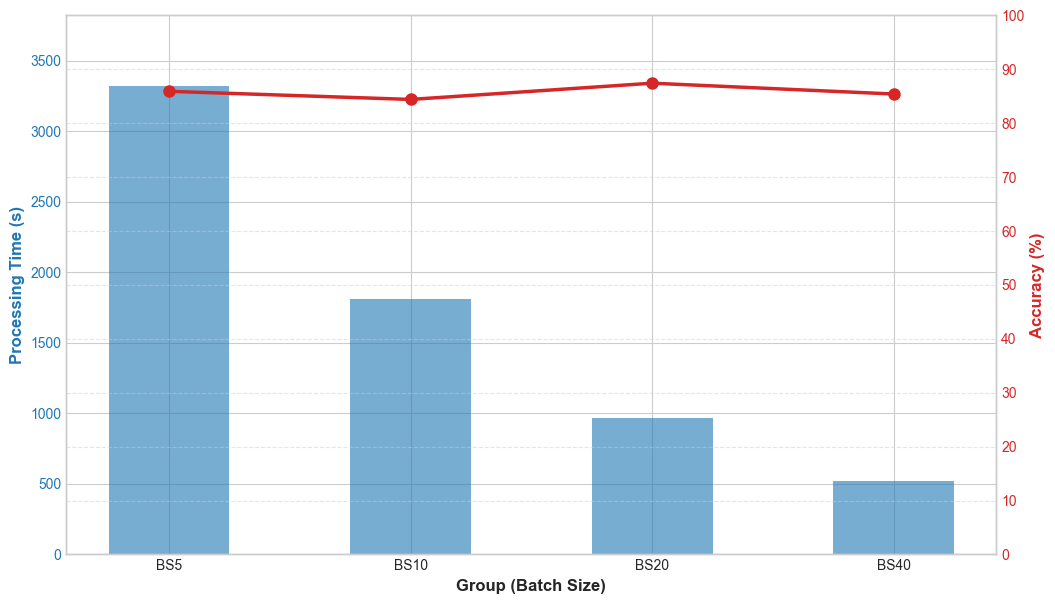

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os

# --- 設定繪圖風格與字型 ---
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except:
    plt.style.use('ggplot') # 如果沒有 seaborn-v0_8 就用 ggplot 替代

plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'SimHei', 'Microsoft JhengHei'] # 支援中文
plt.rcParams['axes.unicode_minus'] = False

# --- 1. 定義檔案路徑 ---
# 請確保這些檔案位於與此腳本相同的目錄中，或修改為絕對路徑
files = {
    '5': {'timer': 'log-copilot_Test_200_BS5_timer.json', 'answers': 'log-copilot_Test_200_BS5_answers.txt'},
    '10': {'timer': 'log-copilot_Test_200_BS10_timer.json', 'answers': 'log-copilot_Test_200_BS10_answers.txt'},
    '20': {'timer': 'log-copilot_Test_200_BS20_timer.json', 'answers': 'log-copilot_Test_200_BS20_answers.txt'},
    '40': {'timer': 'log-copilot_Test_200_BS40_timer.json', 'answers': 'log-copilot_Test_200_BS40_answers.txt'}
}

# --- 2. 讀取並處理數據 ---
results = []
print("正在讀取檔案並計算數據...\n")

for group, paths in files.items():
    # A. 讀取計時器數據 (Timer Data)
    total_seconds = 0
    if os.path.exists(paths['timer']):
        try:
            with open(paths['timer'], 'r', encoding='utf-8') as f:
                timer_data = json.load(f)
                total_seconds = timer_data.get('total_seconds', 0)
        except Exception as e:
            print(f"[錯誤] 無法讀取 {paths['timer']}: {e}")
    else:
        print(f"[警告] 找不到檔案 {paths['timer']}，時間將設為 0")

    # B. 讀取答案數據 (Answers Data)
    accuracy = 0
    correct_count = 0
    total_questions = 0
    
    if os.path.exists(paths['answers']):
        try:
            with open(paths['answers'], 'r', encoding='utf-8') as f:
                answers_data = json.load(f)
                total_questions = len(answers_data)
                correct_count = 0
                for q_id, q_data in answers_data.items():
                    if q_data.get('correct') is True:
                        correct_count += 1
                
                if total_questions > 0:
                    accuracy = (correct_count / total_questions) * 100
        except Exception as e:
            print(f"[錯誤] 無法讀取 {paths['answers']}: {e}")
    else:
        print(f"[警告] 找不到檔案 {paths['answers']}，正確率將設為 0")

    results.append({
        'Group': group,
        'Processing Time (s)': total_seconds,
        'Accuracy (%)': accuracy,
        'Correct Count': correct_count,
        'Total Questions': total_questions
    })

# --- 3. 顯示數據表格 ---
df = pd.DataFrame(results)

# 建立顯示用的 DataFrame (格式化數值，方便閱讀)
df_display = df.copy()
df_display['Accuracy (%)'] = df_display['Accuracy (%)'].apply(lambda x: f"{x:.2f}%")
df_display['Processing Time (s)'] = df_display['Processing Time (s)'].apply(lambda x: f"{x:.1f}")

print("-" * 60)
print("【分析結果彙整】")
print("-" * 60)
print(df_display.to_string(index=False))
print("-" * 60)

# --- 4. 繪製比較圖表 ---
print("\n正在繪製圖表...")
fig, ax1 = plt.subplots(figsize=(12, 7))

# A. 繪製處理時間 (長條圖)
color1 = '#1f77b4' # 藍色
ax1.set_xlabel('Group (Batch Size)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Processing Time (s)', color=color1, fontsize=12, fontweight='bold')
bars = ax1.bar(df['Group'], df['Processing Time (s)'], color=color1, alpha=0.6, label='Processing Time', width=0.5)
ax1.tick_params(axis='y', labelcolor=color1)

# 設定左側 Y 軸範圍
if not df.empty:
    ax1.set_ylim(0, df['Processing Time (s)'].max() * 1.15)

# B. 繪製正確率 (折線圖)
ax2 = ax1.twinx()
color2 = '#d62728' # 紅色
ax2.set_ylabel('Accuracy (%)', color=color2, fontsize=12, fontweight='bold')
line = ax2.plot(df['Group'], df['Accuracy (%)'], color=color2, marker='o', markersize=8, linewidth=2.5, label='Accuracy')
ax2.tick_params(axis='y', labelcolor=color2)

# 設定正確率座標軸 (0-100%，每格10%)
ax2.set_ylim(0, 100)
ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax2.grid(True, which='major', axis='y', linestyle='--', alpha=0.5)

In [ ]:

# C. 加入數值標籤
# 時間標籤
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + (height * 0.02),
             f'{height:.0f}s',
             ha='center', va='bottom', color=color1, fontsize=10, fontweight='bold')

# 正確率標籤
for i, v in enumerate(df['Accuracy (%)']):
    ax2.text(i, v + 3, f"{v:.1f}%", ha='center', color=color2, fontsize=10, fontweight='bold', 
             bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

# D. 圖表修飾與存檔
plt.title('Performance Comparison: Processing Time vs Accuracy', fontsize=16, pad=20)

# 合併圖例 (Legend)
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper center", bbox_to_anchor=(0.5, 0.95), ncol=2)

plt.tight_layout()

# 儲存圖表
output_img = 'batch_size_analysis.png'
plt.savefig(output_img)
print(f"圖表已儲存為: {output_img}")

# 顯示圖表 (如果在有介面的環境下)
plt.show()